## Подготовка

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns
import time
import transformers
m = Mystem()

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

In [2]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
display(data.head())
display(data.describe())from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
display(data.info())
display(data.isnull().sum(axis = 0))

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

text     0
toxic    0
dtype: int64

In [4]:
data[data['text'].str.lower().duplicated(keep=False)].sort_values(by='text').head(10)

,text,toxic
143080,"""\n\n """"wikipedia isn't perfect, but its model...",0
36974,"""\n\n """"wikipedia isn't perfect, but its model...",0
136461,"""\n\n Please do not add nonsense to Wikipedia ...",0
78415,"""\n\n Please do not add nonsense to wikipedia ...",0
16019,"""\n\n Unblock Request \n\n""",0
29636,"""\n\n Unblock request \n\n""",0
96528,"""\n\n unblock request \n\n""",0
135029,"""\n\nPlease do not add nonsense to Wikipedia. ...",0
68816,"""\n\nPlease do not add nonsense to Wikipedia. ...",0
141796,"""Thank you for experimenting with Wikipedia. ...",0


In [5]:
data['text'] = data['text'].str.lower()

In [6]:
data.duplicated().sum()

45

In [7]:
data = data.drop_duplicates().reset_index(drop=True)

In [8]:
data.duplicated().sum()

0

**Вывод:**

Датасет состоит их 159571 строки и двух колонок. Пропусков нет. Целевой признак имеет значение только 0 и 1. После перевода текста твитов в нижний регистр, обнаружили полные дубликаты в количестве 45 строк. Количество незначительное, поэтому данные строки были удалены.

## Обучение

Для обработки текстов используем только 80000 строк, при большем количестве ядро Юпитера умирает.

In [9]:
data = data.sample(80000).reset_index(drop=True)

In [10]:
corpus = data['text'].values.astype('U')

lemmatizer = WordNetLemmatizer()
def lemmatize(twit):
    """ Функция токенизации и лемматизиции теста
    """
    text = re.sub(r'[^a-zA-Z]', ' ', twit)
    word_list = nltk.word_tokenize(text)
    lemmatized_output = " ".join([lemmatizer.lemmatize(i) for i in word_list])
    return " ".join(lemmatized_output.split())

data['lem_text'] = data['text'].apply(lemmatize)

print("Исходный текст:", corpus[0])
print("")
print("Очищенный и лемматизированный текст:", data['lem_text'][0])

Исходный текст: of course, it is always a pleasure to see you.

Очищенный и лемматизированный текст: of course it is always a pleasure to see you


In [ ]:
# Так можно следить за выполнением функции

# from tqdm import tqdm
# warnings.filterwarnings('ignore')

# tqdm.pandas(desc="progress bar!")

# data['text'] = data['text'].progress_apply(lemmatize_sentence)

Разобьём данные на обучающую и тестовую выборки.

In [11]:
features = data.drop('toxic',axis=1)
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.1,
                                                              random_state=12345, stratify=target)

print('Размер тренировочной выборки:',features_train.shape)
print('Размер тренировочной выборки:',target_train.shape)
print('Размер тестовой выборки:',features_test.shape)
print('Размер тренировочной выборки:',target_test.shape)

Размер тренировочной выборки: (72000, 2)
Размер тренировочной выборки: (72000,)
Размер тестовой выборки: (8000, 2)
Размер тренировочной выборки: (8000,)


In [12]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Создадим корпуса из лемматизированных и очищенных слов

In [13]:
corpus_train = features_train['lem_text'].values.astype('U')

print(corpus_train.shape)


(72000,)


In [14]:
corpus_test = features_test['lem_text'].values.astype('U')
print(corpus_test.shape)

(8000,)


Применим модель TfidfVectorizer и обучим её на наших тренировочных данных

In [15]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords, analyzer='word') 

tf_idf_train = count_tf_idf.fit_transform(corpus_train) 
tf_idf_test = count_tf_idf.transform(corpus_test) 

print("Размер матрицы:", tf_idf_train.shape)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (72000, 99225)
Размер матрицы: (8000, 99225)


### Линейная регрессия

In [16]:
%%time
model_LR = LogisticRegression(random_state=12345, max_iter=1000, class_weight='balanced')
 
model_LR.fit(tf_idf_train, target_train)
pred_test_LR = model_LR.predict(tf_idf_test)
F1_LR = f1_score(target_test, pred_test_LR)
print("F1 модели линейной регрессии:", F1_LR)

F1 модели линейной регрессии: 0.7526170798898073
CPU times: user 11.5 s, sys: 14.2 s, total: 25.7 s
Wall time: 25.8 s


In [17]:
%%time
clf_LR = LogisticRegression(random_state=12345, solver='sag',class_weight='balanced')
parametrs_LR = { 'C': range (1, 10),
              'max_iter': range (10,15,2),
              }
grid_LR = GridSearchCV(clf_LR, parametrs_LR, cv=5, scoring='f1')
grid_LR.fit(tf_idf_train, target_train)

predicted_LR = grid_LR.predict(tf_idf_test)

F1_clf_LR = f1_score(target_test, predicted_LR)
#print('Лучшие параметры модели :',grid_LR.best_params_)
print('F1 модели линейной регрессии с GridSearch" :',F1_clf_LR)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

F1 модели линейной регрессии с GridSearch" : 0.7543959160521837
CPU times: user 1min 27s, sys: 248 ms, total: 1min 28s
Wall time: 1min 28s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


### Случайный лес

In [18]:
%%time
model_RFR = RandomForestClassifier()

param_RFR = {'n_estimators' : [1, 12, 4]}

tscv = TimeSeriesSplit(n_splits=3)

model_GS = GridSearchCV(estimator=model_RFR, cv=tscv,
                        param_grid=param_RFR, scoring='f1')

model_GS.fit(tf_idf_train, target_train)
F1_RFR = model_GS.best_score_
#print("Лучшие гиперпараметры модели случайный лес:", model_GS.best_params_)
print("F1 модели случайный лес:", F1_RFR)

F1 модели случайный лес: 0.6227661638422046
CPU times: user 2min 12s, sys: 464 ms, total: 2min 12s
Wall time: 2min 12s


### Градиентный бустинг с LightGBM

In [19]:
#%%time
#model_LGBM = LGBMClassifier(learning_rate=0.1, 
                      #num_leaves=1000, 
                      #random_state=12345)
#model_LGBM.fit(tf_idf_train, target_train)

#predictions_LGBM = model_LGBM.predict(tf_idf_test)

#F1_LGBM = f1_score(target_test, predictions_LGBM)

#print("F1 LightGBM:", F1_LGBM)

### Градиентный бустинг с CatBoost

In [20]:
#%%time
#model_CBR = CatBoostClassifier(random_state=12345,learning_rate=0.4, verbose=100, n_estimators=100)
#model_CBR.fit(tf_idf_train, target_train, eval_set=(tf_idf_test,target_test))
#predict_CBR=model_CBR.predict(tf_idf_test)
#F1_CBR = f1_score(target_test, predict_CBR)

#print("F1 CatBoost:", F1_CBR)

## Выводы

In [21]:
result = {'Learning model': pd.Series([F1_LR, F1_clf_LR, F1_RFR],
                      index=['LogisticRegression', 'LogisticRegression with GridSearch',
                             'RandomForestClassifier'])}
pd.DataFrame(result)

,Learning model
LogisticRegression,0.752617
LogisticRegression with GridSearch,0.754396
RandomForestClassifier,0.622766


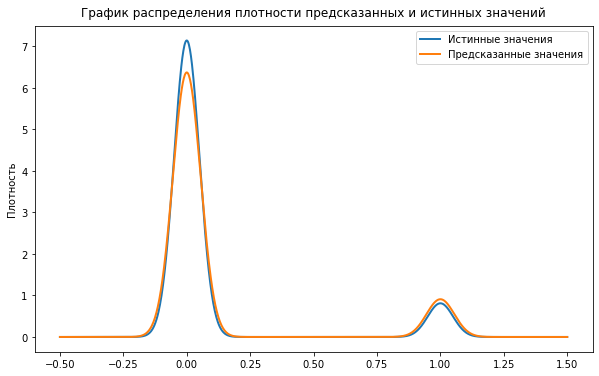

In [22]:
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(pred_test_LR).plot(kind='kde',linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

ROC-AUC: 0.9667841663391415


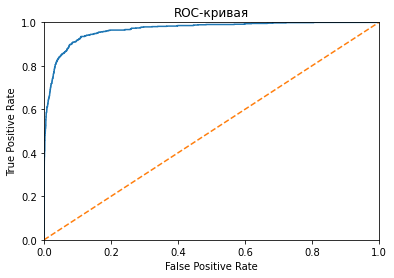

In [23]:
def plt_roc_curve(model, features, target):
    """Построение ROC-кривой и расчет метрики AUC-ROC"""
    probabilities_one_test = model.predict_proba(features)[:, 1]
    print("ROC-AUC:", roc_auc_score(target, probabilities_one_test))
    fpr, tpr, thresholds = roc_curve(target, probabilities_one_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
plt_roc_curve(model_LR, tf_idf_test, target_test)

- Для анализа было взято 80 тыс. строк, которые были обработаны с помощью токенизации и лемматизации;

- Тексты твитов были векторизованы с помощью модели TfidfVectorizer;

- Данные разделены выборки обучающая и тестировочная, в процентном соотношении 90/10 соответственно;

- Для анализа данных были использованы модели обучения: логистическая регрессия, логистическая регрессия с кросс-валидацией, случайный лес. При попытке улучшения метрики F1, была проведена попытка уменьшение выборки, но на результат это не повлияло;

- Лучшей моделью с метрикой F1 стала логистическая регрессия с GridSearch 0.754396. Данную модель можно рекомендовать магазину для поиска токсичных комментариев и дальнейшей их модерации.